# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [124]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [125]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [126]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [127]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [128]:
play = False
if play :
    play_sound(sound) 

In [129]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [130]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

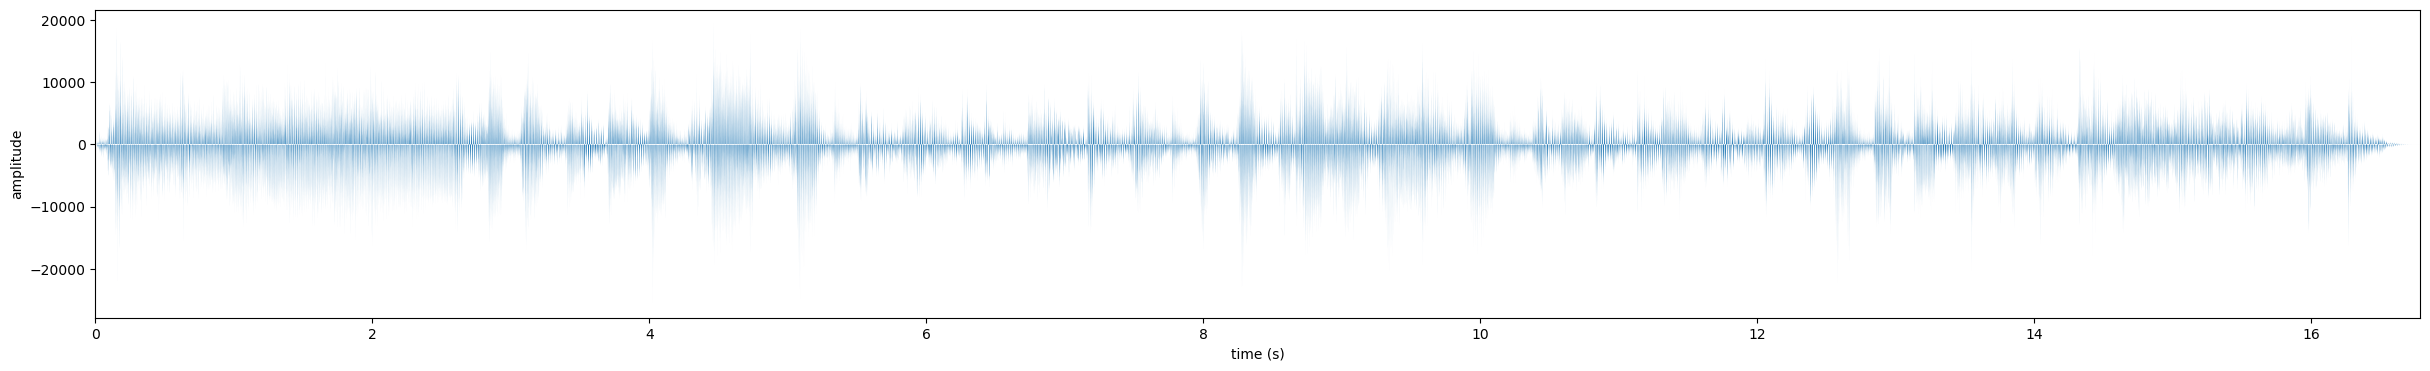

In [131]:
plot_sound(x, times)

In [132]:
write('new_caravan.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

## Signal analysis with the STFT

In [133]:
N = x.shape[0] # % longueur du signal
Nw = 512
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 512 # ordre de la tfd
L = M/2+1
affich = 0 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

In [134]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

In [135]:
if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])
    

## Overlap-add reconstruction

In [136]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

# 2 Conversion of sampling rate

In [137]:
import scipy.signal as signal
import time

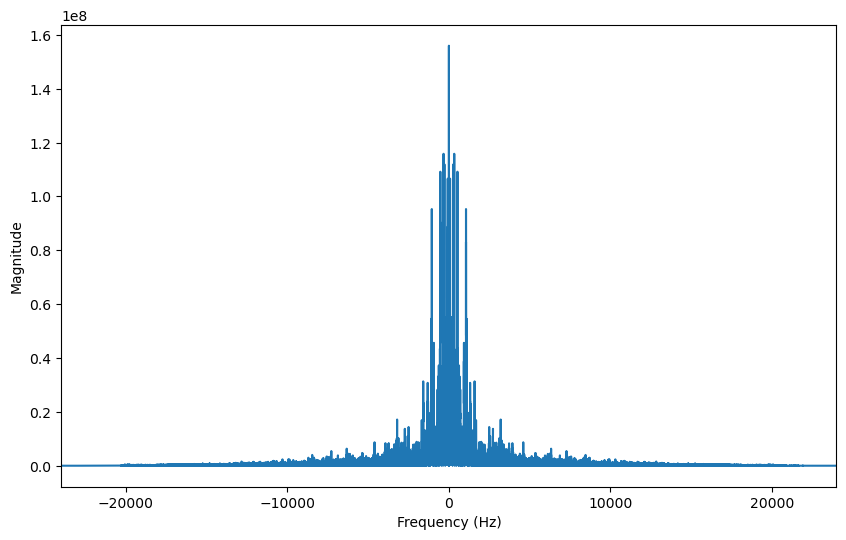

In [138]:
X = np.fft.fft(x)
freq = np.fft.fftfreq(len(X), 1/Fs)

X_shifted = np.fft.fftshift(X)
freq_shifted = np.fft.fftshift(freq)

fig = plt.figure(figsize=(10, 6))
plt.plot(freq_shifted, np.abs(X_shifted))
plt.xlim(-Fs/2, Fs/2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()


## 2.1 Digital processing chain

In order to change the $F_s$ from $F_s=48kHz$ to $F_s=32kHz$, we will first use upsampling by $L=2$ and then followed by a LPF with a cutoff frequency $15kHz$, and then downsampling by $M=3$. 

In [139]:
L = 2
M = 3

LFs = L * Fs

nu_c = 15e3 / LFs
nu_a = 25e3 / LFs
order = 56

h = signal.remez(order, [0, nu_c, nu_a, .5], [2, 0])

def filter(x, h):
    return np.convolve(x, h)


## 2.2 Impulse response of the LPF

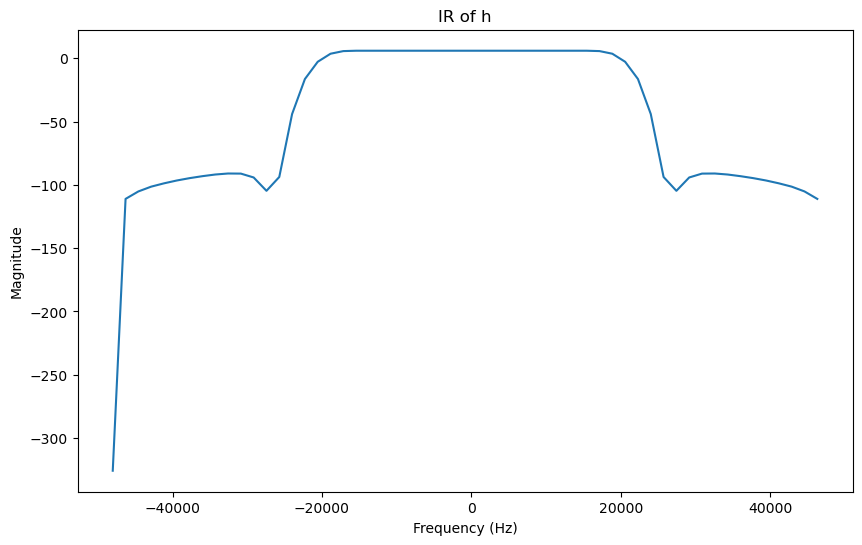

In [140]:
H = np.fft.fft(h)
freq = np.fft.fftfreq(len(H), 1/LFs)

H_shifted = np.fft.fftshift(H)
freq_shifted = np.fft.fftshift(freq)

fig = plt.figure(figsize=(10, 6))
plt.plot(freq_shifted, 20*np.log10(np.abs(H_shifted)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('IR of h')
plt.show()

## 2.3 Process

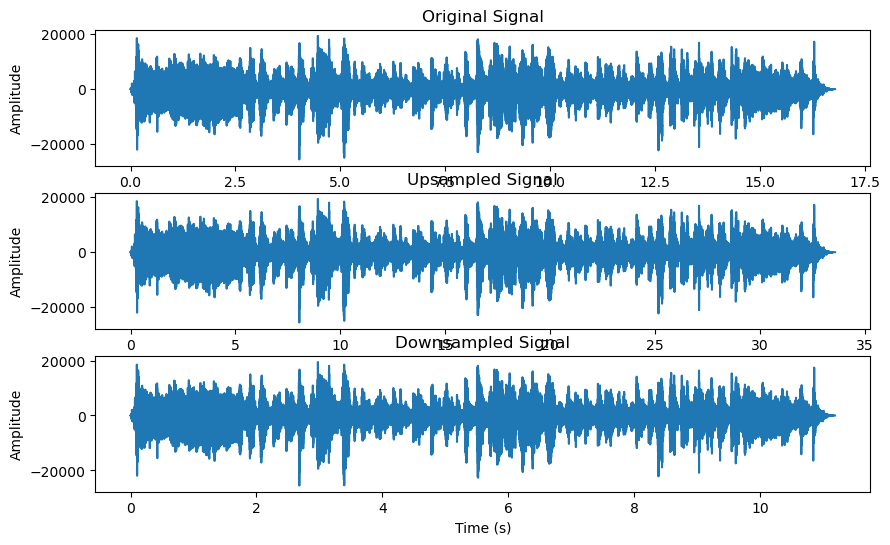

In [141]:
def upsample(signal, L):
    upsampled_signal = np.zeros(int(len(signal) * L))
    upsampled_signal[np.arange(0, len(upsampled_signal), L)] = signal
    return upsampled_signal


def downsample(signal, M):
    return signal[::M]

# upsampling
x_up = upsample(x, L)
# filtering
x_up_filtered = filter(x_up, h)
# downsampling
x_down = downsample(x_up_filtered, M)

# plot
fig, ax = plt.subplots(3, 1, figsize=(10, 6))
ax[0].plot(times, x)
ax[0].set_title('Original Signal')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')

times_up = np.arange(len(x_up)) / Fs
ax[1].plot(times_up, x_up)
ax[1].set_title('Upsampled Signal')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Amplitude')

times_down = np.arange(len(x_down)) / Fs
ax[2].plot(times_down, x_down)
ax[2].set_title('Downsampled Signal')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Amplitude')

plt.show()

## 2.4 Verification of two processing chains


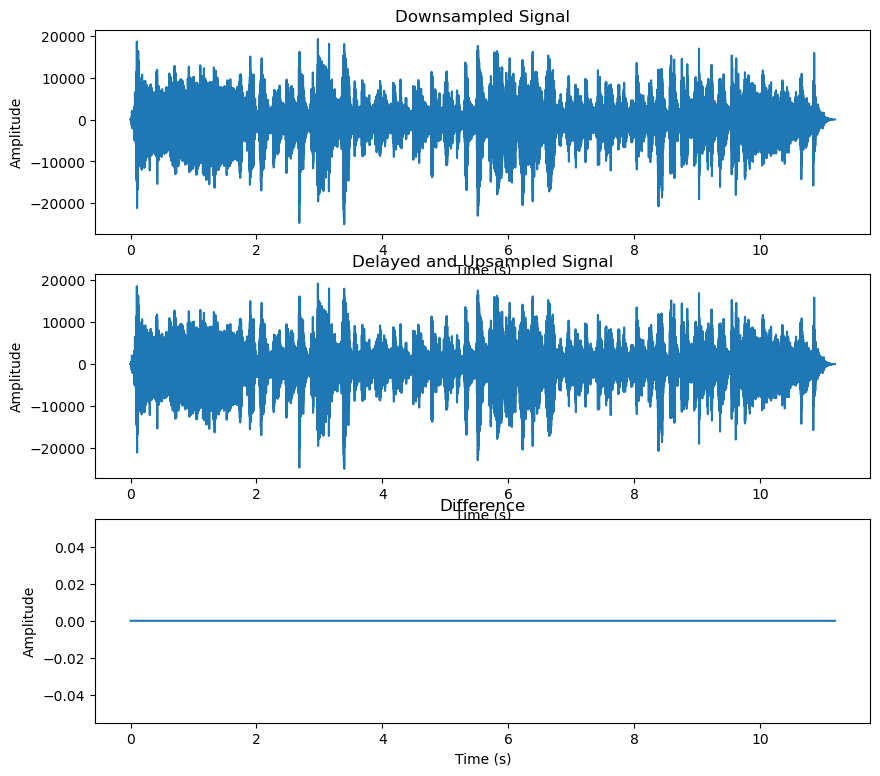

In [142]:
# First case : Up = 2, z^-1, Down = 3
x_up = upsample(x, 2)
x_up = x_up[1:]
x_down = downsample(x_up, 3)

# Second case : z, Down = 3, Up = 2, z^-1
x_delay = np.zeros(1)
x_delay = np.append(x_delay, x)
x_delay_down = downsample(x_delay, 3)
x_delay_up = upsample(x_delay_down, 2)
x_delay_up = x_delay_up[1:]

# plot
fig, ax = plt.subplots(3, 1, figsize=(10, 9))
times_down = np.arange(len(x_down)) / Fs
ax[0].plot(times_down, x_down)
ax[0].set_title('Downsampled Signal')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')

times_delay_up = np.arange(len(x_delay_up)) / Fs
ax[1].plot(times_delay_up, x_delay_up)
ax[1].set_title('Delayed and Upsampled Signal')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Amplitude')

diff = x_down - x_delay_up
ax[2].plot(times_down, diff)
ax[2].set_title('Difference')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Amplitude')

plt.show()

## 2.5 and 2.6 Polyphase implementation and comparison

In [143]:
t_start = time.time()
x0=np.zeros(x.shape[0]//3)
x1=np.zeros(x.shape[0]//3)
x2=np.zeros(x.shape[0]//3)

for i in range(x.shape[0]//3):
    x0[i]=x[i*3]
    x1[i]=x[i*3+1]
    x2[i]=x[i*3+2]

R0 = np.zeros(h.shape[0]//2)
R1 = np.zeros(h.shape[0]//2)

for j in range(h.shape[0]//2):
    R0[j]=h[j*2]
    R1[j]=h[j*2+1]

E00=np.zeros(R0.shape[0]//3)
E01=np.zeros(R0.shape[0]//3)
E02=np.zeros(R0.shape[0]//3)

E10=np.zeros(R1.shape[0]//3)
E11=np.zeros(R1.shape[0]//3)
E12=np.zeros(R1.shape[0]//3)

for i in range(R1.shape[0]//3):
    E10[i]=R1[i*3]
    E11[i]=R1[i*3+1]
    E12[i]=R1[i*3+2]
    E00[i]=R0[i*3]
    E01[i]=R0[i*3+1]
    E02[i]=R0[i*3+2]

E00 = np.convolve(E00,x0)
E01 = np.convolve(E01,x1)
E02 = np.convolve(E02,x2)

E10 = np.convolve(E10,x0)
E11 = np.convolve(E11,x1)
E12 = np.convolve(E12,x2)

E0 = E00+E01+E02
E1 = E10+E11+E12

E0 = upsample(E0,2)
E0 = np.insert(E0,0,0)

E1 = upsample(E1,2)
E1 = np.append(E1,0)

xPolyphase = E0+E1
t_end = time.time()
print('Time elapsed :', t_end-t_start)

Time elapsed : 0.3047940731048584


# 3 STFT audio equalization

## 3.1 Hanning Window

/var/folders/4v/n41dv2b1147ds406__7xy7zm0000gn/T/ipykernel_16091/1202574855.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freq_shifted, 20*np.log10(np.abs(W_shifted)))


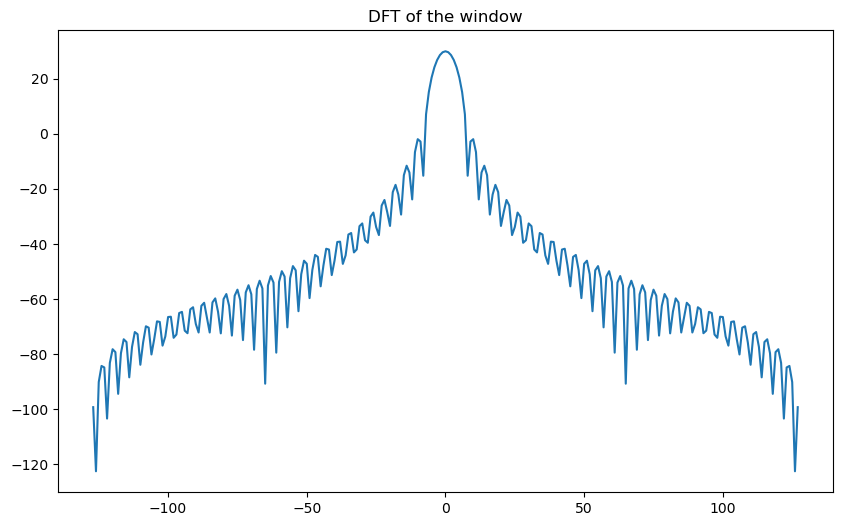

In [144]:
Nw = 64
M = 256 # order of DFT
w = np.hanning(Nw) # window

W = np.fft.fft(w,M)
freq = np.fft.fftfreq(M, 1/M)

W_shifted = np.fft.fftshift(W)
freq_shifted = np.fft.fftshift(freq)

fig = plt.figure(figsize=(10, 6))
plt.plot(freq_shifted, 20*np.log10(np.abs(W_shifted)))
plt.title('DFT of the window')
plt.show()

## 3.2 Convolution Explanation of STFT

 $Wx(\lambda , b) =\sum_{n \in \mathbb{Z}} x(n)w(n - b)e^{ -j2\pi \lambda n}$ ,which can be combined as $Wx(\lambda , b) =\sum_{n \in \mathbb{Z}} x(n)\left(w(n - b)e^{ -j2\pi \lambda n}\right)$. Therefore, the term $w(n - b)e^{ -j2\pi \lambda n}$ is a filter. If $w(n)$ is a low-pass filter, then $w(n-b)$ is shifted by $b$, which is a band-pass filter. If the window $w(n)$ is even, then $w(n-b)$ will also be even, making it a Type 1 FIR filter. If the window $w(n)$ is odd, then $w(n-b)$ will also be odd, making it a Type 3 FIR filter.

## 3.3 Band pass Convention

$\tilde{X}(\lambda,b) = W_x(\lambda,b) e^{j2\pi \lambda b}$ and this notebook implements the "band-pass convention".

## 3.4 Calculate $x_k$

In [145]:
N = x.shape[0] # % longueur du signal
Nw = 512
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 512 # ordre de la tfd
L = M/2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add


In [146]:
k = 3
xk = Xtilde[k-1,:]
print(xk)

[ 6.60481429e+03-3.24065537e+03j -6.89056977e+03+6.32304995e+03j
  2.95793816e+03-1.67842374e+04j ... -1.06350752e+01+1.11152659e+01j
  1.09991893e+01-2.70938763e+00j -5.84191392e+00-1.71483042e+00j]


This shows that $x_k$ is complexe.

/var/folders/4v/n41dv2b1147ds406__7xy7zm0000gn/T/ipykernel_16091/3894506965.py:1: UserWarning: Input data is complex, switching to return_onesided=False
  SX = signal.spectrogram(xk)[2]


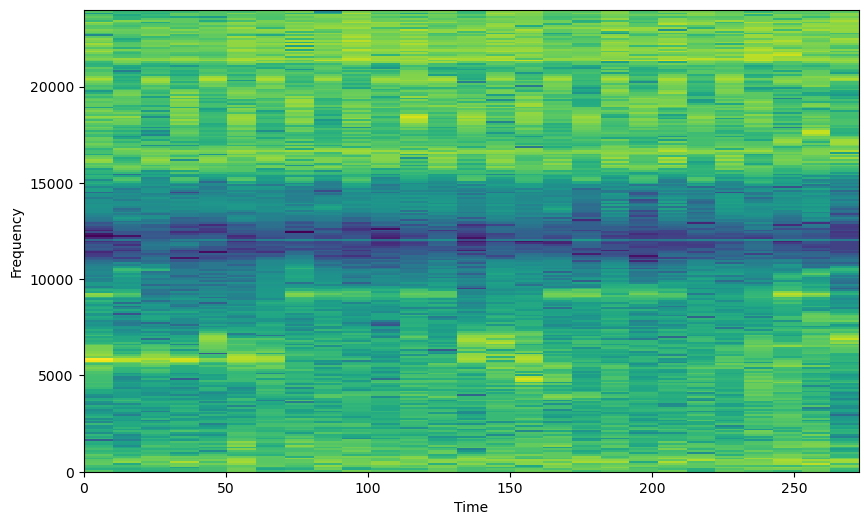

In [147]:
SX = signal.spectrogram(xk)[2]
lx = len(SX)
SX = np.concatenate([SX[lx//2:], SX[:lx//2]])
freq = np.arange(-lx//2, lx//2)/lx

fig = plt.figure(figsize=(10, 6))
plt.imshow(20*np.log10(np.abs(SX)), aspect='auto',interpolation='none', origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

/var/folders/4v/n41dv2b1147ds406__7xy7zm0000gn/T/ipykernel_16091/1266200290.py:3: UserWarning: Input data is complex, switching to return_onesided=False
  SF = signal.spectrogram(x_filter)[2]


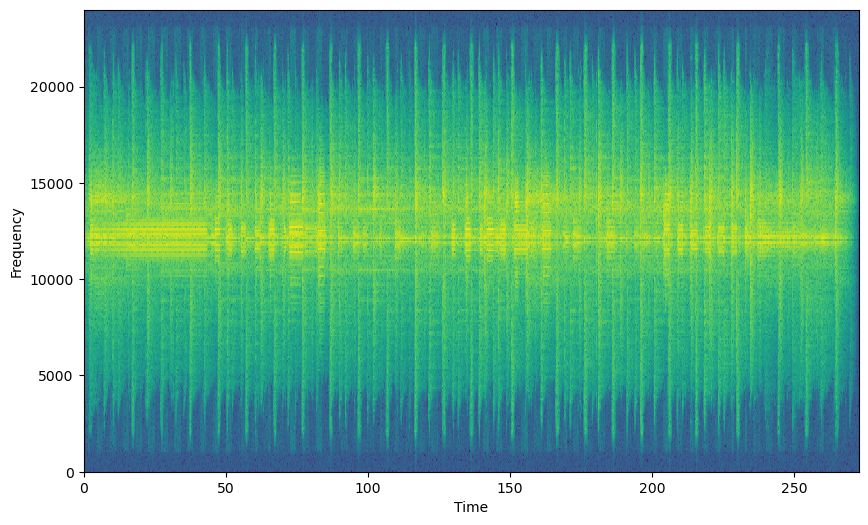

In [148]:
x_filter = signal.lfilter([1], [1,-0.9*np.exp(2j*np.pi*3/32)],x)

SF = signal.spectrogram(x_filter)[2]
lx = len(SF)
SF = np.concatenate([SF[lx//2:], SF[:lx//2]])
freq = np.arange(-lx//2, lx//2)/lx

fig = plt.figure(figsize=(10, 6))
plt.imshow(20*np.log10(np.abs(SF)), aspect='auto',interpolation='none', origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()


## 3.5 Perfect reconstruction Condition 

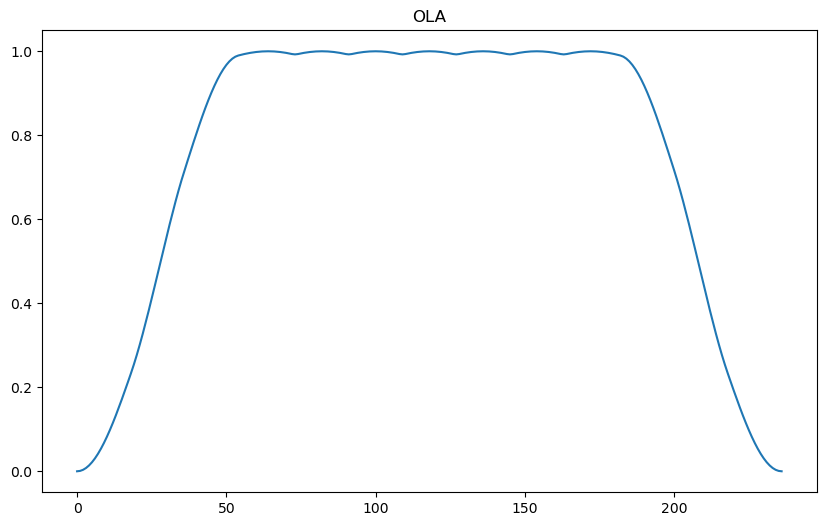

In [149]:
Nw = 75
w = np.hanning(Nw)

wp = w**2
y = ola(w = w,hop = int(Nw/4),Nb = 10)
y = y/np.max(np.abs(y))

fig = plt.figure(figsize=(10, 6))
plt.plot(y)
plt.title('OLA')
plt.show()


## 3.6 Resynthesis

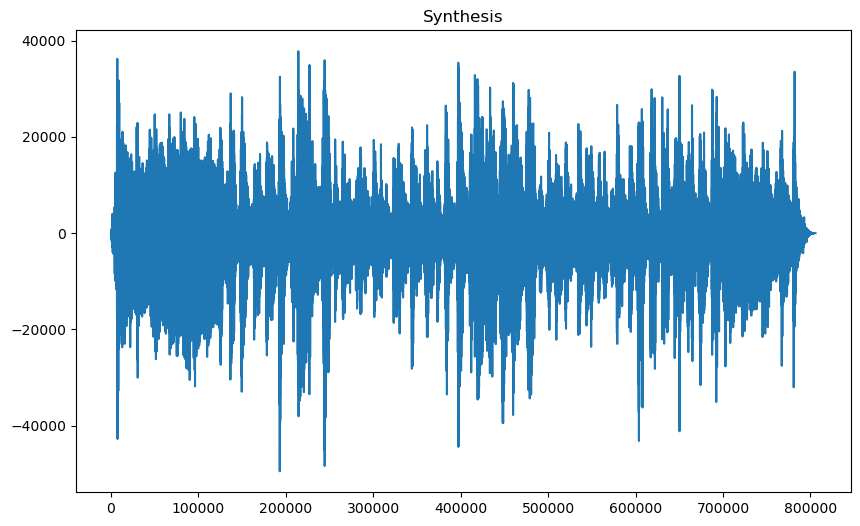

In [150]:
N = len(x)
Nw = 32
w = np.hanning(Nw)
R = Nw / 4 # hop size
M = 32 # order of stft
L = M // 2 + 1

Nt = int((N - Nw) / R)
y = np.zeros(N)

for u in range(Nt):
    deb = int(u * R)
    fin = deb + Nw
    tx = x[deb:fin] * w
    X = np.fft.fft(tx, M)
    Y = X.copy()
    y[deb:fin] += np.real(np.fft.ifft(Y))

fig = plt.figure(figsize=(10, 6))
plt.plot(y)
plt.title('Synthesis')
plt.show()


## 3.7 Equalizer

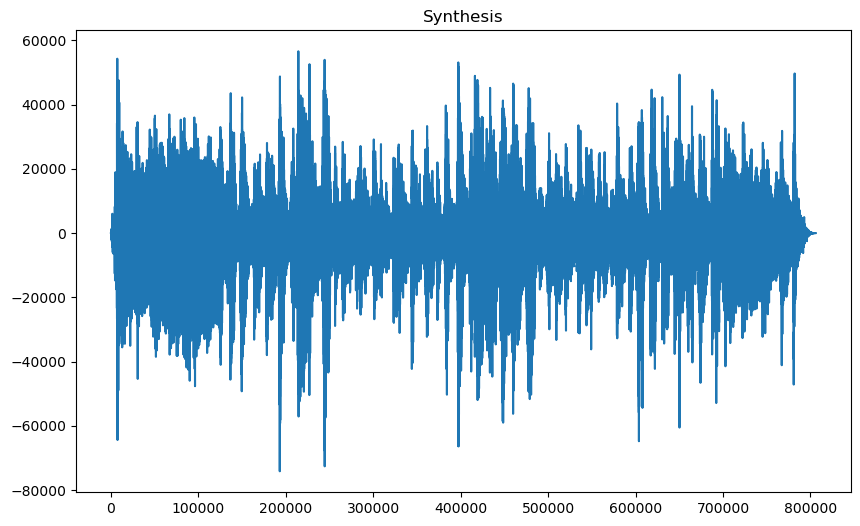

In [151]:
N = len(x)
Nw = 32
w = np.hanning(Nw)
R = Nw / 4 # hop size
M = 32 # order of stft
L = M // 2 + 1

wk = np.ones(M)
wk[0:int(L/2)] = 1.5
wk[int(L/2):L] = 0.1
wk[L+1:M-int(L/2)] = 0.1
wk[M-int(L/2)+1:M] = 1.5

Nt = int((N - Nw) / R)
y = np.zeros(N)

for u in range(Nt):
    deb = int(u * R)
    fin = deb + Nw
    tx = x[deb:fin] * w
    X = np.fft.fft(tx, M)
    Xeq = X * wk
    Y = Xeq.copy()
    y[deb:fin] += np.real(np.fft.ifft(Y))

fig = plt.figure(figsize=(10, 6))
plt.plot(y)
plt.title('Synthesis')
plt.show()
